<a href="https://www.kaggle.com/chiehjulin/tps-mar-2022?scriptVersionId=89873919" target="_blank"><img align="left" alt="Kaggle" title="Open in Kaggle" src="https://kaggle.com/static/images/open-in-kaggle.svg"></a>

# Introduction

<div style="font-size:16px; color:#4169E1; font-family:verdana;">
In this competition, we'll forecast twelve-hours of traffic flow in a major U.S. metropolitan area. Time, space, and directional features give us the chance to model interactions across a network of roadways.
</div>

# Imports

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns

from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
from sklearn.preprocessing import LabelEncoder, OrdinalEncoder

from xgboost import XGBRegressor
from catboost import CatBoostRegressor
from lightgbm import LGBMRegressor

from datetime import datetime

import warnings
import time
pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)
pd.set_option('float_format', '{:f}'.format)
warnings.filterwarnings('ignore')

RANDOM_STATE = 18
FOLDS = 5

In [2]:
train = pd.read_csv('/kaggle/input/tabular-playground-series-mar-2022/train.csv')
test = pd.read_csv('/kaggle/input/tabular-playground-series-mar-2022/test.csv')
submission = pd.read_csv('/kaggle/input/tabular-playground-series-mar-2022/test.csv')

# Exploring Train Data

<div class = "alert alert-info" role = "alert" style="font-size:14px; font-family:verdana;">

📌 <b><u>Observations in Train Data</u></b><br>

* There are <b><u>6</u></b> columns: <b><u>1</u></b> row_id, <b><u>1</u></b> datetime, <b><u>3</u></b> categorical, and <b><u>1</u></b> continuous<br>   (x, y are considered as categorical as only few values available in each column)<br>
* There are total of <b><u>848,834</u></b> rows in train dataset<br>
* <b><u>"congestion"</u></b> is the our target variable, which is a continuous variable with range from <b><u>0</u></b> to <b><u>100</u></b><br>
* There are no missing / null values in this dataset<br>
* This is a <b><u>time series</u></b> analysis
    
</div>

<div style="font-size:16px; color:#4169E1; font-family:verdana;">
Check Train data
</div>

In [3]:
train.head()

,row_id,time,x,y,direction,congestion
0,0,1991-04-01 00:00:00,0,0,EB,70
1,1,1991-04-01 00:00:00,0,0,NB,49
2,2,1991-04-01 00:00:00,0,0,SB,24
3,3,1991-04-01 00:00:00,0,1,EB,18
4,4,1991-04-01 00:00:00,0,1,NB,60


In [4]:
print(f'\033[92mNumber of rows in the table: {train.shape[0]}')
print(f'\033[94mNumber of columns in the table: {train.shape[1]}')
print(f'\033[91mNumber of observations in the table: {train.count().sum()}')
print(f'\033[91mNumber of missing values in the table: {sum(train.isnull().sum())}')
print(f'\033[91mNumber of duplicated records: {train.duplicated().sum()}')
print()
print(f'\033[95mData types')
print(f'\033[90m{train.dtypes}')
print()
print(f'\033[95mData type counts')
print(f'\033[90m{train.dtypes.value_counts()}')
print()
print(f'\033[95mUnique value in each column')
print(f'\033[90m{train.nunique()}')

Number of rows in the table: 848835
Number of columns in the table: 6
Number of observations in the table: 5093010
Number of missing values in the table: 0
Number of duplicated records: 0

Data types
row_id         int64
time          object
x              int64
y              int64
direction     object
congestion     int64
dtype: object

Data type counts
int64     4
object    2
dtype: int64

Unique value in each column
row_id        848835
time           13059
x                  3
y                  4
direction          8
congestion       101
dtype: int64


<div style="font-size:16px; color:#4169E1; font-family:verdana;">
Check null values
</div>

In [5]:
train.isnull().sum()

row_id        0
time          0
x             0
y             0
direction     0
congestion    0
dtype: int64

<div style="font-size:16px; color:#4169E1; font-family:verdana;">
Quick view on continuous columns
</div>

In [6]:
train.describe()

,row_id,x,y,congestion
count,848835.000000,848835.000000,848835.000000,848835.000000
mean,424417.000000,1.138462,1.630769,47.815305
std,245037.702210,0.801478,1.089379,16.799392
min,0.000000,0.000000,0.000000,0.000000
25%,212208.500000,0.000000,1.000000,35.000000
50%,424417.000000,1.000000,2.000000,47.000000
75%,636625.500000,2.000000,3.000000,60.000000
max,848834.000000,2.000000,3.000000,100.000000


# Exploring Test Data

<div class = "alert alert-info" role = "alert" style="font-size:14px; font-family:verdana;">

📌 <b><u>Observations in Test Data</u></b><br>

* There are <b><u>6</u></b> columns: <b><u>1</u></b> row_id, <b><u>1</u></b> datetime, <b><u>3</u></b> categorical, and <b><u>1</u></b> continuous<br>
* There are total of <b><u>2,340</u></b> rows in test dataset, which is around just <b><u>0.27%</u></b> of Train Data<br>
* There are no missing / null values in this dataset
    
</div>

<div style="font-size:16px; color:#4169E1; font-family:verdana;">
Check test data
</div>

In [7]:
test.head()

,row_id,time,x,y,direction
0,848835,1991-09-30 12:00:00,0,0,EB
1,848836,1991-09-30 12:00:00,0,0,NB
2,848837,1991-09-30 12:00:00,0,0,SB
3,848838,1991-09-30 12:00:00,0,1,EB
4,848839,1991-09-30 12:00:00,0,1,NB


In [8]:
print(f'\033[92mNumber of rows in the table: {test.shape[0]}')
print(f'\033[94mNumber of columns in the table: {test.shape[1]}')
print(f'\033[91mNumber of observations in the table: {test.count().sum()}')
print(f'\033[91mNumber of missing values in the table: {sum(test.isnull().sum())}')
print(f'\033[91mNumber of duplicated records: {test.duplicated().sum()}')
print()
print(f'\033[95mData types')
print(f'\033[90m{test.dtypes}')
print()
print(f'\033[95mData type counts')
print(f'\033[90m{test.dtypes.value_counts()}')
print()
print(f'\033[95mUnique value in each column')
print(f'\033[90m{test.nunique()}')

Number of rows in the table: 2340
Number of columns in the table: 5
Number of observations in the table: 11700
Number of missing values in the table: 0
Number of duplicated records: 0

Data types
row_id        int64
time         object
x             int64
y             int64
direction    object
dtype: object

Data type counts
int64     3
object    2
dtype: int64

Unique value in each column
row_id       2340
time           36
x               3
y               4
direction       8
dtype: int64


<div style="font-size:16px; color:#4169E1; font-family:verdana;">
Check null values
</div>

In [9]:
test.isnull().sum()

row_id       0
time         0
x            0
y            0
direction    0
dtype: int64

In [10]:
print("Test set rows / Train set rows = " + str(round(test.count()[0] / train.count()[0] * 100, 2)))

Test set rows / Train set rows = 0.28


# Basic Exploratory Data Analysis

<div class = "alert alert-info" role = "alert" style="font-size:14px; font-family:verdana;">

🔍 <b><u>Check List</u></b><br>

* Distriution of categorical variabless between train and test set<br>
    - Seems to be quite similar<br>
  <br>
* Relationship between categorical variables and target variable<br>
    - Some directions have lower average congestion value compare with others<br>
  <br>
* Relationship between date and target variable<br>
    - There seems to be a trend<br>
    
</div>

In [11]:
train['time'] = pd.to_datetime(train['time'], format='%Y-%m-%d %H:%M:%S')
test['time'] = pd.to_datetime(test['time'], format='%Y-%m-%d %H:%M:%S')

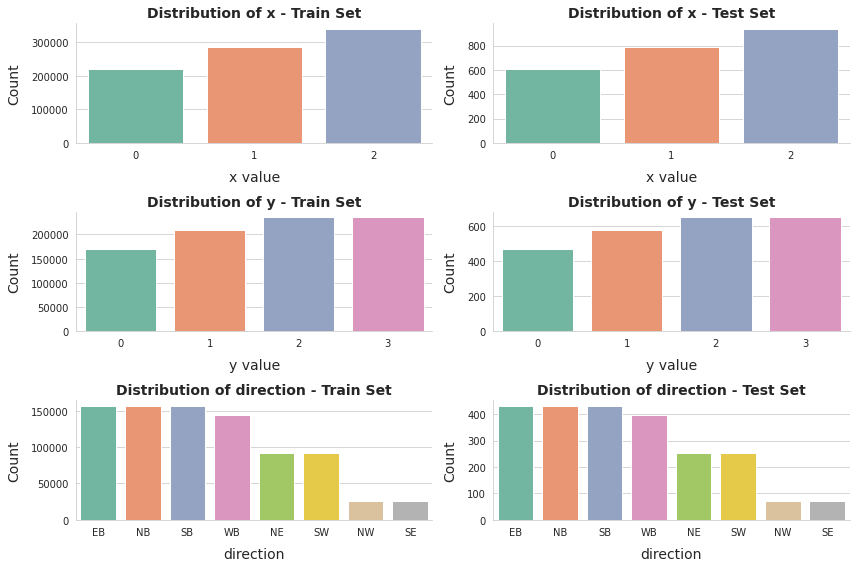

In [12]:
sns.set_style('whitegrid')
fig = plt.figure(figsize = (12, 8))

# x distribution
ax1 = fig.add_subplot(3, 2, 1)

sns.countplot(x = 'x', data = train, palette="Set2")
plt.xticks()

ax1.spines['right'].set_visible(False)
ax1.spines['top'].set_visible(False)

ax1.set_xlabel("x value", fontsize=14, labelpad=10)
ax1.set_ylabel("Count", fontsize=14, labelpad=10)
ax1.set_title('Distribution of x - Train Set', loc = 'center', fontsize = 14, fontweight = 'bold')

ax2 = fig.add_subplot(3, 2, 2)

sns.countplot(x = 'x', data = test, palette="Set2")
plt.xticks()

ax2.spines['right'].set_visible(False)
ax2.spines['top'].set_visible(False)

ax2.set_xlabel("x value", fontsize=14, labelpad=10)
ax2.set_ylabel("Count", fontsize=14, labelpad=10)
ax2.set_title('Distribution of x - Test Set', loc = 'center', fontsize = 14, fontweight = 'bold')

# y distribution
ax3 = fig.add_subplot(3, 2, 3)

sns.countplot(x = 'y', data = train, palette="Set2")
plt.xticks()

ax3.spines['right'].set_visible(False)
ax3.spines['top'].set_visible(False)

ax3.set_xlabel("y value", fontsize=14, labelpad=10)
ax3.set_ylabel("Count", fontsize=14, labelpad=10)
ax3.set_title('Distribution of y - Train Set', loc = 'center', fontsize = 14, fontweight = 'bold')

ax4 = fig.add_subplot(3, 2, 4)

sns.countplot(x = 'y', data = test, palette="Set2")
plt.xticks()

ax4.spines['right'].set_visible(False)
ax4.spines['top'].set_visible(False)

ax4.set_xlabel("y value", fontsize=14, labelpad=10)
ax4.set_ylabel("Count", fontsize=14, labelpad=10)
ax4.set_title('Distribution of y - Test Set', loc = 'center', fontsize = 14, fontweight = 'bold')

# direction distribution
ax5 = fig.add_subplot(3, 2, 5)

sns.countplot(x = 'direction', data = train, palette="Set2")
plt.xticks()

ax5.spines['right'].set_visible(False)
ax5.spines['top'].set_visible(False)

ax5.set_xlabel("direction", fontsize=14, labelpad=10)
ax5.set_ylabel("Count", fontsize=14, labelpad=10)
ax5.set_title('Distribution of direction - Train Set', loc = 'center', fontsize = 14, fontweight = 'bold')

ax6 = fig.add_subplot(3, 2, 6)

sns.countplot(x = 'direction', data = test, palette="Set2")
plt.xticks()

ax6.spines['right'].set_visible(False)
ax6.spines['top'].set_visible(False)

ax6.set_xlabel("direction", fontsize=14, labelpad=10)
ax6.set_ylabel("Count", fontsize=14, labelpad=10)
ax6.set_title('Distribution of direction - Test Set', loc = 'center', fontsize = 14, fontweight = 'bold')
fig.tight_layout()

In [13]:
categorical_columns = train[['x', 'y', 'direction']].columns.to_numpy()

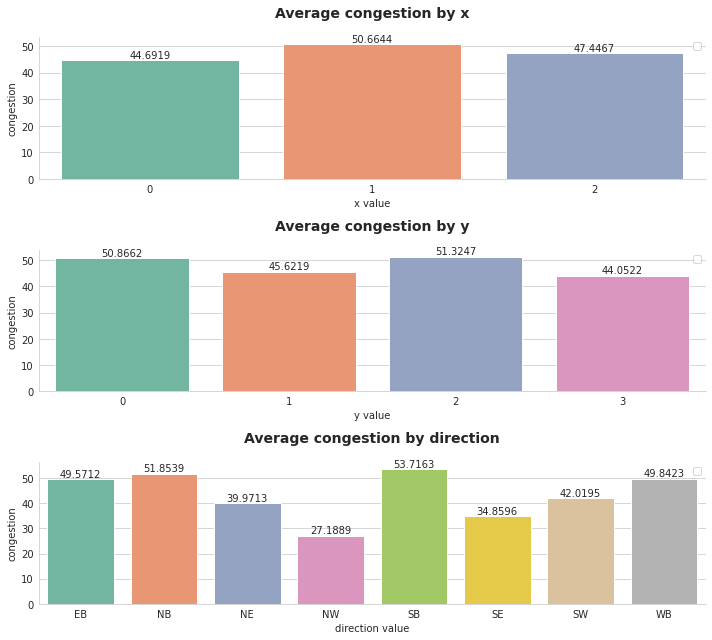

In [14]:
fig = plt.figure(figsize = (10, 9))
rows = 3
cols = 1

for idx, categorical_column in enumerate(categorical_columns):
  ax = fig.add_subplot(rows, cols, idx + 1)
  sns.barplot(x = categorical_column, y = 'congestion', data = train.groupby(categorical_column).mean('congestion')['congestion'].reset_index(), palette = 'Set2')
  
  ax.xaxis.set_tick_params(labelsize=10, size=0, pad=5)
  ax.yaxis.set_tick_params(labelsize=10, size=0, pad=5)

  ax.spines['right'].set_visible(False)
  ax.spines['top'].set_visible(False)
    
  ax.set_ylabel('congestion')

  ax.set_xlabel(categorical_column + " value")
  ax.bar_label(ax.containers[0])
  
  ax.set_title('Average congestion by ' + categorical_column, loc = 'center', fontsize = 14, fontweight = 'bold', pad = 20)

  ax.legend()

fig.tight_layout()
fig.show()

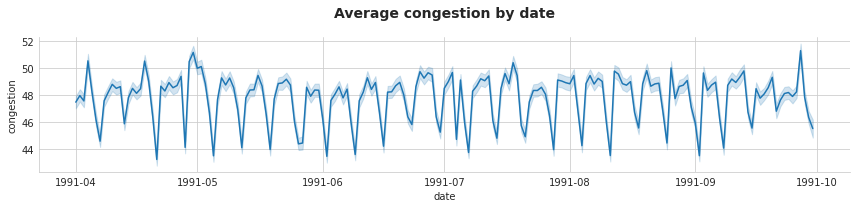

In [15]:
fig = plt.figure(figsize = (12, 3))

# date
ax = fig.add_subplot(1, 1, 1)
sns.lineplot(x = train['time'].dt.date, y = 'congestion', data = train)

ax.xaxis.set_tick_params(labelsize=10, size=0, pad=5)
ax.yaxis.set_tick_params(labelsize=10, size=0, pad=5)

ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)

ax.set_ylabel('congestion')

ax.set_xlabel('date')

ax.set_title('Average congestion by date', loc = 'center', fontsize = 14, fontweight = 'bold', pad = 20)

fig.tight_layout()
fig.show()

# Feature Engineering

<div class = "alert alert-info" role = "alert" style="font-size:14px; font-family:verdana;">

🔍 <b><u>Some Ideas & Hypothesis</u></b><br>

* <u><b>Week of day</b></u> might have impact on congestion<br>
    - Yes, weekend have lower average congestion values<br>
    <br>
* <u><b>Busy hours</b></u> might have impact on congestion<br>
    - Yes, from noon to 8 pm. the average congestion values are above 50<br>
    <br>
* <u><b>Holidays</b></u> might have impact on congestion
    - Yes, congestion values are lower on <b><u>Memorial's day</u></b>, <b><u>July 4th</u></b>, and <b><u>Labor day</u></b><br>
    <br>
* x, y, and direction might have <u><b>combined effect</b></u> on congestion<br>

    
</div>

<div style="font-size:16px; color:#4169E1; font-family:verdana;">
Let's create some new features based on <b><u>time</u></b> column
</div>

In [16]:
from pandas.tseries.holiday import USFederalHolidayCalendar
cal = USFederalHolidayCalendar()
holidays = cal.holidays(start='1991-01-01', end='1991-12-01')

In [17]:
print('US Holidays in 1991')
holidays

US Holidays in 1991


DatetimeIndex(['1991-01-01', '1991-01-21', '1991-02-18', '1991-05-27',
               '1991-07-04', '1991-09-02', '1991-10-14', '1991-11-11',
               '1991-11-28'],
              dtype='datetime64[ns]', freq=None)

In [18]:
def feature_engineering(data):   
    data['month'] = data['time'].dt.month
    data['day'] = data['time'].dt.day
    data['time_part'] = data['time'].dt.time
    data['hour'] = data['time'].dt.hour
    data['minute'] = data['time'].dt.minute
    data['weekday'] = data['time'].dt.strftime("%A")
    data['x_y'] = data['x'].map(str) + '-' + data['y'].map(str)
    data['x_y_direction'] = data['x'].map(str) + '-' + data['y'].map(str) + '-' + data['direction']
    data['direction_hour'] = data['direction'] + '-' + data['time'].dt.hour.map(str)
    data['holiday'] = np.where(data['time'].isin(holidays), 'Yes', 'No')
    return data

In [19]:
for data in [train, test]:
    data = feature_engineering(data)

In [20]:
train[train['holiday'] == 'Yes'][['time', 'weekday', 'holiday']].drop_duplicates()

,time,weekday,holiday
261105,1991-05-27,Monday,Yes
438620,1991-07-04,Thursday,Yes
717795,1991-09-02,Monday,Yes


In [21]:
train.head()

,row_id,time,x,y,direction,congestion,month,day,time_part,hour,minute,weekday,x_y,x_y_direction,direction_hour,holiday
0,0,1991-04-01,0,0,EB,70,4,1,00:00:00,0,0,Monday,0-0,0-0-EB,EB-0,No
1,1,1991-04-01,0,0,NB,49,4,1,00:00:00,0,0,Monday,0-0,0-0-NB,NB-0,No
2,2,1991-04-01,0,0,SB,24,4,1,00:00:00,0,0,Monday,0-0,0-0-SB,SB-0,No
3,3,1991-04-01,0,1,EB,18,4,1,00:00:00,0,0,Monday,0-1,0-1-EB,EB-0,No
4,4,1991-04-01,0,1,NB,60,4,1,00:00:00,0,0,Monday,0-1,0-1-NB,NB-0,No


<div style="font-size:16px; color:#4169E1; font-family:verdana;">
Check differences between days of the week
</div>

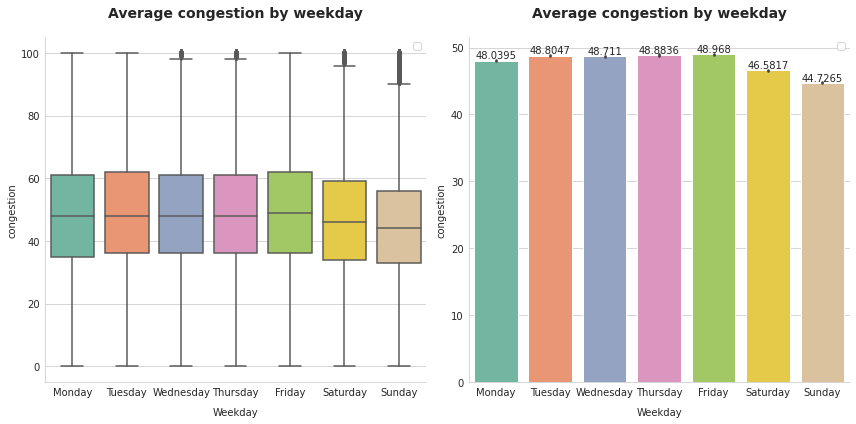

In [22]:
fig = plt.figure(figsize = (12, 6))

# boxplot
ax1 = fig.add_subplot(1, 2, 1)

sns.boxplot(x = 'weekday', y = 'congestion', data = train, palette = 'Set2')

ax1.xaxis.set_tick_params(labelsize=10, size=0, pad=5)
ax1.yaxis.set_tick_params(labelsize=10, size=0, pad=5)

ax1.spines['right'].set_visible(False)
ax1.spines['top'].set_visible(False)

ax1.set_ylabel('congestion')

ax1.set_xlabel('Weekday', labelpad = 10)

ax1.set_title('Average congestion by weekday', loc = 'center', fontsize = 14, fontweight = 'bold', pad = 20)

ax1.legend()

# barplot
ax2 = fig.add_subplot(1, 2, 2)

sns.barplot(x = 'weekday', y = 'congestion', data = train, palette = 'Set2')

ax2.xaxis.set_tick_params(labelsize=10, size=0, pad=5)
ax2.yaxis.set_tick_params(labelsize=10, size=0, pad=5)

ax2.spines['right'].set_visible(False)
ax2.spines['top'].set_visible(False)

ax2.set_ylabel('congestion')

ax2.set_xlabel('Weekday', labelpad = 10)

ax2.set_title('Average congestion by weekday', loc = 'center', fontsize = 14, fontweight = 'bold', pad = 20)
ax2.bar_label(ax2.containers[0])
ax2.legend()

fig.tight_layout()
fig.show()

<div style="font-size:16px; color:#4169E1; font-family:verdana;">
Check congestion by time
</div>

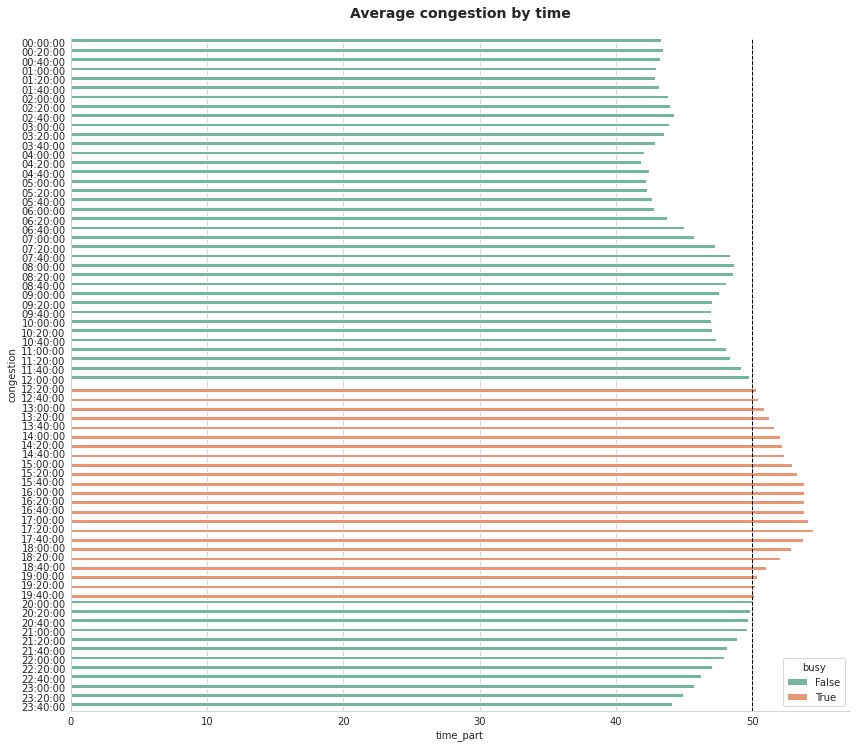

In [23]:
temp = train.groupby('time_part').mean('congestion')['congestion'].reset_index()
temp['busy'] = temp['congestion'] >= 50

fig = plt.figure(figsize = (12, 20))

# time
ax = fig.add_subplot(2, 1, 2)
sns.barplot(x = 'congestion', y = 'time_part', hue = 'busy', data = temp, palette = 'Set2')

ax.xaxis.set_tick_params(labelsize=10, size=0, pad=5)
ax.yaxis.set_tick_params(labelsize=10, size=0, pad=5)

ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)

ax.axvline(50, ls = '--', lw = 1, color = 'black')

ax.set_ylabel('congestion')

ax.set_xlabel('time_part')

ax.set_title('Average congestion by time', loc = 'center', fontsize = 14, fontweight = 'bold', pad = 20)

fig.tight_layout()
fig.show()

<div style="font-size:16px; color:#4169E1; font-family:verdana;">
Check impact on holidays
</div>

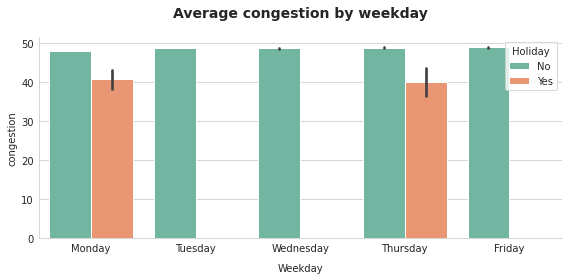

In [24]:
fig = plt.figure(figsize = (8, 4))

# boxplot
ax1 = fig.add_subplot(1, 1, 1)

sns.barplot(x = 'weekday', y = 'congestion', hue = 'holiday', data = train[~train['weekday'].isin(['Saturday', 'Sunday'])], palette = 'Set2')

ax1.xaxis.set_tick_params(labelsize=10, size=0, pad=5)
ax1.yaxis.set_tick_params(labelsize=10, size=0, pad=5)

ax1.spines['right'].set_visible(False)
ax1.spines['top'].set_visible(False)

ax1.set_ylabel('congestion')

ax1.set_xlabel('Weekday', labelpad = 10)

ax1.set_title('Average congestion by weekday', loc = 'center', fontsize = 14, fontweight = 'bold', pad = 20)

ax1.legend(title = 'Holiday', loc = 'upper right')

fig.tight_layout()
fig.show()

<div style="font-size:16px; color:#4169E1; font-family:verdana;">
Let's drop records on holidays as they could be outliers in the data
</div>

In [25]:
train = train[train['holiday'] == 'No'].drop(['holiday'], axis = 1)
test = test.drop(['holiday'], axis = 1)

<div style="font-size:16px; color:#4169E1; font-family:verdana;">
Check combined effect
</div>

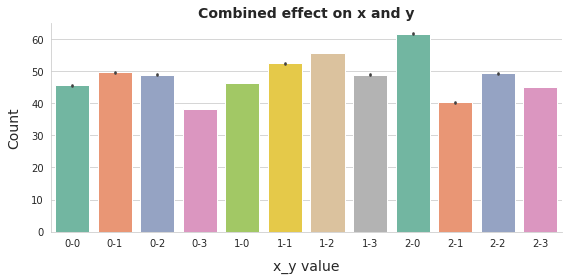

In [26]:
sns.set_style('whitegrid')
fig = plt.figure(figsize = (8, 4))

# x distribution
ax = fig.add_subplot(1, 1, 1)

sns.barplot(x = 'x_y', y = 'congestion', data = train, palette="Set2")
plt.xticks()

ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)

ax.set_xlabel("x_y value", fontsize=14, labelpad=10)
ax.set_ylabel("Count", fontsize=14, labelpad=10)
ax.set_title('Combined effect on x and y', loc = 'center', fontsize = 14, fontweight = 'bold')

fig.tight_layout()

# Model Building

In [27]:
train.drop(['row_id', 'time'], axis = 1, inplace = True)
test.drop(['row_id', 'time'], axis = 1, inplace = True)

In [28]:
TARGET = 'congestion'
FEATURES = [col for col in train.columns if col not in ['row_id', TARGET]]

In [29]:
enc = OrdinalEncoder()
enc.fit(train[FEATURES])
train[FEATURES] = enc.transform(train[FEATURES]).astype(int)
test[FEATURES] = enc.transform(test[FEATURES]).astype(int)

In [30]:
train.head()

,x,y,direction,congestion,month,day,time_part,hour,minute,weekday,x_y,x_y_direction,direction_hour
0,0,0,0,70,0,0,0,0,0,1,0,0,0
1,0,0,1,49,0,0,0,0,0,1,0,1,24
2,0,0,4,24,0,0,0,0,0,1,0,2,96
3,0,1,0,18,0,0,0,0,0,1,1,3,0
4,0,1,1,60,0,0,0,0,0,1,1,4,24


In [31]:
test.head()

,x,y,direction,month,day,time_part,hour,minute,weekday,x_y,x_y_direction,direction_hour
0,0,0,0,5,29,36,12,0,1,0,0,4
1,0,0,1,5,29,36,12,0,1,0,1,28
2,0,0,4,5,29,36,12,0,1,0,2,100
3,0,1,0,5,29,36,12,0,1,1,3,4
4,0,1,1,5,29,36,12,0,1,1,4,28


In [32]:
catb_params = {
    'objective': 'MAE',
    'cat_features': FEATURES,
    'task_type': 'GPU'
}

In [33]:
catb_predictions = []
catb_mae = []
catb_r2 = []
catb_fimp = []


cv = StratifiedKFold(n_splits = FOLDS, shuffle = True, random_state = RANDOM_STATE)
for fold, (train_idx, valid_idx) in enumerate(cv.split(train[FEATURES], train[TARGET])):
    
    print(10*"=", f"Fold = {fold + 1}", 10*"=")
    start_time = time.time()
    
    X_train, X_valid = train.iloc[train_idx][FEATURES], train.iloc[valid_idx][FEATURES]
    y_train, y_valid = train[TARGET].iloc[train_idx], train[TARGET].iloc[valid_idx]
    
    model = CatBoostRegressor(**catb_params)
    model.fit(X_train, y_train, verbose = 0)
    
    pred_valid = model.predict(X_valid)
    
    mae = mean_absolute_error(y_valid, pred_valid)
    catb_mae.append(mae)
    
    r2 = r2_score(y_valid, pred_valid)
    catb_r2.append(r2)
    
    run_time = time.time() - start_time
    
    print(f"Fold = {fold + 1}, MAE: {mae:.2f}, R2: {r2:.2f}, Run Time: {run_time:.2f}s")
    test_pred = model.predict(test[FEATURES])
    fim = pd.DataFrame(index = FEATURES,
                      data = model.feature_importances_,
                      columns = [f'{fold}_importance'])
    catb_fimp.append(fim)
    catb_predictions.append(test_pred)
    
print("Mean MAE :", np.mean(catb_mae), "Mean R2 :", np.mean(catb_r2))

========== Fold = 1 ==========
Fold = 1, MAE: 6.24, R2: 0.71, Run Time: 135.64s
========== Fold = 2 ==========
Fold = 2, MAE: 6.29, R2: 0.71, Run Time: 65.63s
========== Fold = 3 ==========
Fold = 3, MAE: 6.29, R2: 0.71, Run Time: 66.00s
========== Fold = 4 ==========
Fold = 4, MAE: 6.31, R2: 0.71, Run Time: 65.66s
========== Fold = 5 ==========
Fold = 5, MAE: 6.29, R2: 0.71, Run Time: 66.07s
Mean MAE : 6.283427456261329 Mean R2 : 0.7107942011913931


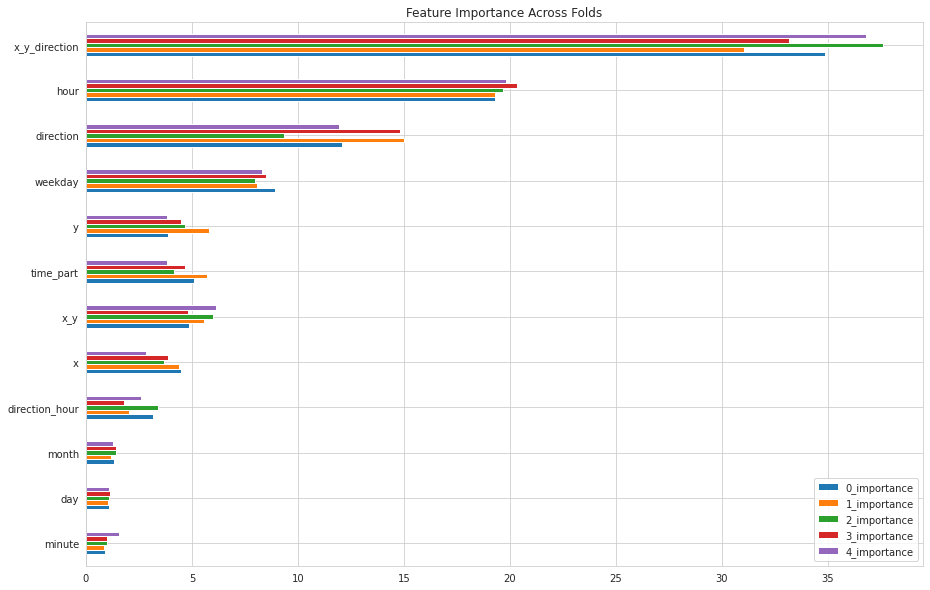

In [34]:
catb_fis_df = pd.concat(catb_fimp, axis = 1).head(15)
catb_fis_df.sort_values('1_importance').plot(kind = 'barh', figsize = (15, 10), title = 'Feature Importance Across Folds')
plt.legend(loc='lower right')
plt.show()

In [35]:
catb_submission = submission.copy()[['row_id']]
catb_submission["congestion"] = np.clip(np.round(np.squeeze(np.mean(np.column_stack(catb_predictions),axis = 1)), 0), 0, 100).astype(int)
catb_submission.to_csv("catb.csv",index=False)
catb_submission.head()

,row_id,congestion
0,848835,46
1,848836,37
2,848837,50
3,848838,27
4,848839,71


In [36]:
xgb_params = {  
    'n_estimators': 1000,
    'tree_method': 'gpu_hist',    
    'predictor': 'gpu_predictor', 
    'booster': 'gbtree',         
    'eta': 0.3,                   
    'gamma': 0,                   
    'max_depth': 6,               
    'lambda': 1,                  
    'alpha': 0,                  
}

In [37]:
xgb_predictions = []
xgb_mae = []
xgb_r2 = []
xgb_fimp = []


cv = StratifiedKFold(n_splits = FOLDS, shuffle = True, random_state = RANDOM_STATE)
for fold, (train_idx, valid_idx) in enumerate(cv.split(train[FEATURES], train[TARGET])):
    
    print(10*"=", f"Fold = {fold + 1}", 10*"=")
    start_time = time.time()
    
    X_train, X_valid = train.iloc[train_idx][FEATURES], train.iloc[valid_idx][FEATURES]
    y_train, y_valid = train[TARGET].iloc[train_idx], train[TARGET].iloc[valid_idx]
    
    model = XGBRegressor(**xgb_params)
    model.fit(X_train, y_train, verbose = 0)
    
    pred_valid = model.predict(X_valid)
    
    mae = mean_absolute_error(y_valid, pred_valid)
    xgb_mae.append(mae)
    
    r2 = r2_score(y_valid, pred_valid)
    xgb_r2.append(r2)
    
    run_time = time.time() - start_time
    
    print(f"Fold = {fold + 1}, MAE: {mae:.2f}, R2: {r2:.2f}, Run Time: {run_time:.2f}s")
    test_pred = model.predict(test[FEATURES])
    fim = pd.DataFrame(index = FEATURES,
                      data = model.feature_importances_,
                      columns = [f'{fold}_importance'])
    xgb_fimp.append(fim)
    xgb_predictions.append(test_pred)
    
print("Mean MAE :", np.mean(xgb_mae), "Mean R2 :", np.mean(xgb_r2))

========== Fold = 1 ==========
Fold = 1, MAE: 6.07, R2: 0.74, Run Time: 6.75s
========== Fold = 2 ==========
Fold = 2, MAE: 6.08, R2: 0.74, Run Time: 4.86s
========== Fold = 3 ==========
Fold = 3, MAE: 6.09, R2: 0.74, Run Time: 4.78s
========== Fold = 4 ==========
Fold = 4, MAE: 6.09, R2: 0.74, Run Time: 4.88s
========== Fold = 5 ==========
Fold = 5, MAE: 6.09, R2: 0.74, Run Time: 4.79s
Mean MAE : 6.085045841688552 Mean R2 : 0.7368013896673615


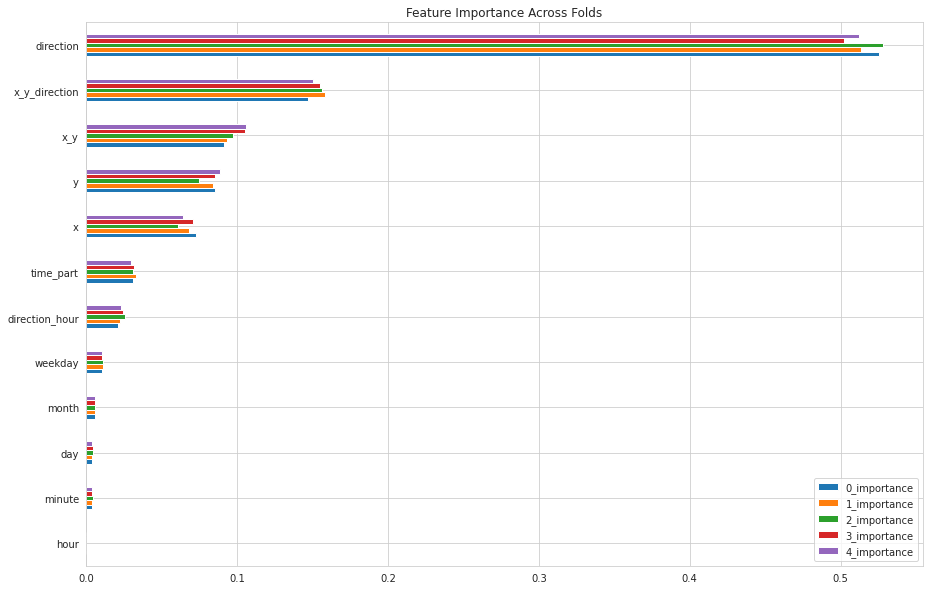

In [38]:
xgb_fis_df = pd.concat(xgb_fimp, axis = 1).head(15)
xgb_fis_df.sort_values('1_importance').plot(kind = 'barh', figsize = (15, 10), title = 'Feature Importance Across Folds')
plt.legend(loc='lower right')
plt.show()

In [39]:
xgb_submission = submission.copy()[['row_id']]
xgb_submission["congestion"] = np.clip(np.round(np.squeeze(np.mean(np.column_stack(xgb_predictions),axis = 1)), 0), 0, 100).astype(int)
xgb_submission.to_csv("xgb.csv",index=False)
xgb_submission.head()

,row_id,congestion
0,848835,49
1,848836,38
2,848837,50
3,848838,26
4,848839,69


In [40]:
lgb_params = {
    'objective': 'mean_absolute_error',    
    'metric': 'mae',    
    'device': 'gpu',              
    'n_estimators': 1000,        
    'learning_rate': 0.1,        
    'num_leaves': 31,            
    'max_depth': -1,              
    'bagging_freq': 0,            
    'feature_fraction': 1,        
    'lambda_l1': 0,               
    'lambda_l2': 0,              
}

In [41]:
lgb_predictions = []
lgb_mae = []
lgb_r2 = []
lgb_fimp = []


cv = StratifiedKFold(n_splits = FOLDS, shuffle = True, random_state = RANDOM_STATE)
for fold, (train_idx, valid_idx) in enumerate(cv.split(train[FEATURES], train[TARGET])):
    
    print(10*"=", f"Fold = {fold + 1}", 10*"=")
    start_time = time.time()
    
    X_train, X_valid = train.iloc[train_idx][FEATURES], train.iloc[valid_idx][FEATURES]
    y_train, y_valid = train[TARGET].iloc[train_idx], train[TARGET].iloc[valid_idx]
    
    model = LGBMRegressor(**lgb_params)
    model.fit(X_train, y_train, verbose = 0)
    
    pred_valid = model.predict(X_valid)
    
    mae = mean_absolute_error(y_valid, pred_valid)
    lgb_mae.append(mae)
    
    r2 = r2_score(y_valid, pred_valid)
    lgb_r2.append(r2)
    
    run_time = time.time() - start_time
    
    print(f"Fold = {fold + 1}, MAE: {mae:.2f}, R2: {r2:.2f}, Run Time: {run_time:.2f}s")
    test_pred = model.predict(test[FEATURES])
    fim = pd.DataFrame(index = FEATURES,
                      data = model.feature_importances_,
                      columns = [f'{fold}_importance'])
    lgb_fimp.append(fim)
    lgb_predictions.append(test_pred)
    
print("Mean MAE :", np.mean(lgb_mae), "Mean R2 :", np.mean(lgb_r2))

========== Fold = 1 ==========
[LightGBM] [Warning] lambda_l1 is set=0, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0
[LightGBM] [Warning] feature_fraction is set=1, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=1
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] lambda_l2 is set=0, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0
Fold = 1, MAE: 6.15, R2: 0.71, Run Time: 37.20s
========== Fold = 2 ==========
[LightGBM] [Warning] lambda_l1 is set=0, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0
[LightGBM] [Warning] feature_fraction is set=1, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=1
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] lambda_l2 is set=0, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0
Fold = 2, MAE: 6.16, R2: 0.71, Run T

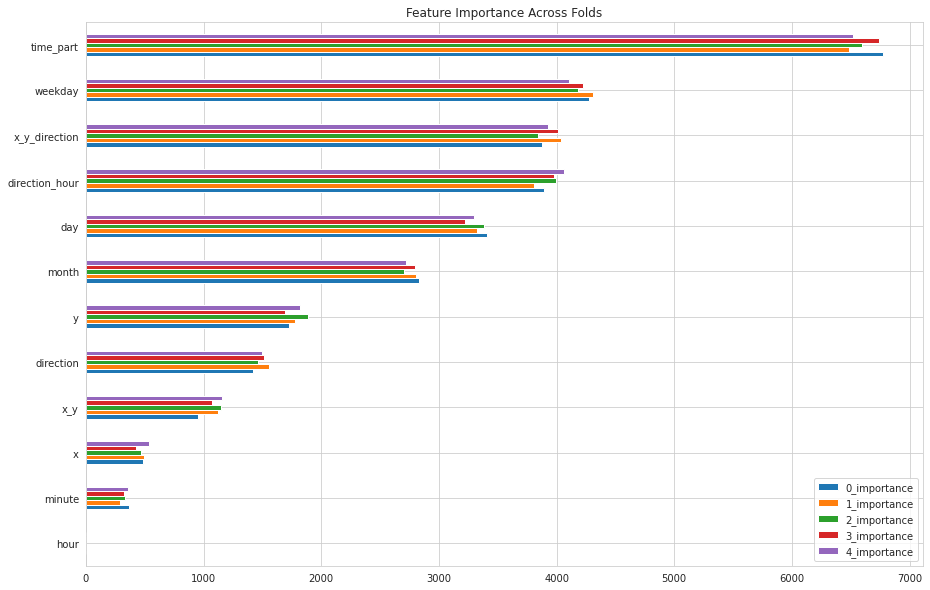

In [42]:
lgb_fis_df = pd.concat(lgb_fimp, axis = 1).head(15)
lgb_fis_df.sort_values('1_importance').plot(kind = 'barh', figsize = (15, 10), title = 'Feature Importance Across Folds')
plt.legend(loc='lower right')
plt.show()

In [43]:
lgb_submission = submission.copy()[['row_id']]
lgb_submission["congestion"] = np.clip(np.round(np.squeeze(np.mean(np.column_stack(lgb_predictions),axis = 1)), 0), 0, 100).astype(int)
lgb_submission.to_csv("lgb.csv",index=False)
lgb_submission.head()

,row_id,congestion
0,848835,47
1,848836,36
2,848837,47
3,848838,26
4,848839,70


<div style="font-size:16px; color:#4169E1; font-family:verdana;">
Average of 3 models
</div>

In [44]:
mean_submission = submission.copy()
pred_mean = np.clip(np.round(np.squeeze(np.mean(np.column_stack(xgb_predictions + lgb_predictions + catb_predictions),axis = 1)), 0), 0, 100).astype(int)
mean_submission["target"] = pred_mean
mean_submission.to_csv("pred_mean.csv",index=False)
mean_submission.head()

,row_id,time,x,y,direction,target
0,848835,1991-09-30 12:00:00,0,0,EB,47
1,848836,1991-09-30 12:00:00,0,0,NB,37
2,848837,1991-09-30 12:00:00,0,0,SB,49
3,848838,1991-09-30 12:00:00,0,1,EB,26
4,848839,1991-09-30 12:00:00,0,1,NB,70


In [45]:
'''
X_train, X_valid, y_train, y_valid = train_test_split(train[FEATURES].values, train[TARGET].values, test_size = 0.2, random_state=5)

cv = StratifiedKFold(n_splits = FOLDS, shuffle = True, random_state = RANDOM_STATE)

model = CatBoostRegressor(objective = 'RMSE', cat_features = FEATURES, task_type = 'GPU')

grid = {
    'iterations': np.arange(10, 500, 10),
    'depth': np.arange(2, 16, 2),
    'learning_rate': [0.01, 0.05, 0.1]
        }

model_random = RandomizedSearchCV(estimator = model, param_distributions = grid, n_iter = 5, 
                                  cv = cv, verbose=1, random_state=RANDOM_STATE)
model_random.fit(train[FEATURES], train[TARGET])
'''

"\nX_train, X_valid, y_train, y_valid = train_test_split(train[FEATURES].values, train[TARGET].values, test_size = 0.2, random_state=5)\n\ncv = StratifiedKFold(n_splits = FOLDS, shuffle = True, random_state = RANDOM_STATE)\n\nmodel = CatBoostRegressor(objective = 'RMSE', cat_features = FEATURES, task_type = 'GPU')\n\ngrid = {\n    'iterations': np.arange(10, 500, 10),\n    'depth': np.arange(2, 16, 2),\n    'learning_rate': [0.01, 0.05, 0.1]\n        }\n\nmodel_random = RandomizedSearchCV(estimator = model, param_distributions = grid, n_iter = 5, \n                                  cv = cv, verbose=1, random_state=RANDOM_STATE)\nmodel_random.fit(train[FEATURES], train[TARGET])\n"

In [46]:
'''
print(model_random.cv_results_)

print(" Results from Grid Search " )
print("\n The best estimator across ALL searched params:\n", model_random.best_estimator_)
print("\n The best score across ALL searched params:\n", model_random.best_score_)
print("\n The best parameters across ALL searched params:\n", model_random.best_params_)
'''

'\nprint(model_random.cv_results_)\n\nprint(" Results from Grid Search " )\nprint("\n The best estimator across ALL searched params:\n", model_random.best_estimator_)\nprint("\n The best score across ALL searched params:\n", model_random.best_score_)\nprint("\n The best parameters across ALL searched params:\n", model_random.best_params_)\n'

In [47]:
'''
model_random.predict(test[FEATURES])
'''

'\nmodel_random.predict(test[FEATURES])\n'

In [48]:
'''
catb_grid_submission = submission.copy()[['row_id']]
catb_grid_submission["congestion"] = np.clip(np.round(model_random.predict(test[FEATURES]), 0), 0, 100).astype(int)
catb_grid_submission.to_csv("catb_grid.csv",index=False)
catb_grid_submission.head()
'''

'\ncatb_grid_submission = submission.copy()[[\'row_id\']]\ncatb_grid_submission["congestion"] = np.clip(np.round(model_random.predict(test[FEATURES]), 0), 0, 100).astype(int)\ncatb_grid_submission.to_csv("catb_grid.csv",index=False)\ncatb_grid_submission.head()\n'

<div style="font-size:16px; color:#4169E1; font-family:verdana;">
What if we train model using only Monday data and exclude holidays?
</div>

In [49]:
# NEW_FEATURES = [i for i in FEATURES if i not in ['weekday', 'holiday']]

In [50]:
# train[(train['weekday'] == 1) & (train['holiday'] == 0)][NEW_FEATURES]

In [51]:
#catb_params = {
#    'objective': 'MAE',
#    'cat_features': NEW_FEATURES,
#    'task_type': 'GPU'
#}

In [52]:
'''
catb_monday_predictions = []
catb_monday_mae = []
catb_monday_r2 = []
catb_monday_fimp = []


cv = StratifiedKFold(n_splits = FOLDS, shuffle = True, random_state = RANDOM_STATE)
for fold, (train_idx, valid_idx) in enumerate(cv.split(train[(train['weekday'] == 1) & (train['holiday'] == 0)][NEW_FEATURES], train[(train['weekday'] == 1) & (train['holiday'] == 0)][TARGET])):
    
    print(10*"=", f"Fold = {fold + 1}", 10*"=")
    start_time = time.time()
    
    X_train, X_valid = train[(train['weekday'] == 1) & (train['holiday'] == 0)].iloc[train_idx][NEW_FEATURES], train[(train['weekday'] == 1) & (train['holiday'] == 0)].iloc[valid_idx][NEW_FEATURES]
    y_train, y_valid = train[(train['weekday'] == 1) & (train['holiday'] == 0)][TARGET].iloc[train_idx], train[(train['weekday'] == 1) & (train['holiday'] == 0)][TARGET].iloc[valid_idx]
    
    model = CatBoostRegressor(**catb_params)
    model.fit(X_train, y_train, verbose = 0)
    
    pred_valid = model.predict(X_valid)
    
    mae = mean_absolute_error(y_valid, pred_valid)
    catb_monday_mae.append(mae)
    
    r2 = r2_score(y_valid, pred_valid)
    catb_monday_r2.append(r2)
    
    run_time = time.time() - start_time
    
    print(f"Fold = {fold + 1}, MAE: {mae:.2f}, R2: {r2:.2f}, Run Time: {run_time:.2f}s")
    test_pred = model.predict(test[NEW_FEATURES])
    fim = pd.DataFrame(index = NEW_FEATURES,
                      data = model.feature_importances_,
                      columns = [f'{fold}_importance'])
    catb_monday_fimp.append(fim)
    catb_monday_predictions.append(test_pred)
    
print("Mean MAE :", np.mean(catb_monday_mae), "Mean R2 :", np.mean(catb_monday_r2))
'''

'\ncatb_monday_predictions = []\ncatb_monday_mae = []\ncatb_monday_r2 = []\ncatb_monday_fimp = []\n\n\ncv = StratifiedKFold(n_splits = FOLDS, shuffle = True, random_state = RANDOM_STATE)\nfor fold, (train_idx, valid_idx) in enumerate(cv.split(train[(train[\'weekday\'] == 1) & (train[\'holiday\'] == 0)][NEW_FEATURES], train[(train[\'weekday\'] == 1) & (train[\'holiday\'] == 0)][TARGET])):\n    \n    print(10*"=", f"Fold = {fold + 1}", 10*"=")\n    start_time = time.time()\n    \n    X_train, X_valid = train[(train[\'weekday\'] == 1) & (train[\'holiday\'] == 0)].iloc[train_idx][NEW_FEATURES], train[(train[\'weekday\'] == 1) & (train[\'holiday\'] == 0)].iloc[valid_idx][NEW_FEATURES]\n    y_train, y_valid = train[(train[\'weekday\'] == 1) & (train[\'holiday\'] == 0)][TARGET].iloc[train_idx], train[(train[\'weekday\'] == 1) & (train[\'holiday\'] == 0)][TARGET].iloc[valid_idx]\n    \n    model = CatBoostRegressor(**catb_params)\n    model.fit(X_train, y_train, verbose = 0)\n    \n    pred_va

In [53]:
'''
catb_fis_df = pd.concat(catb_monday_fimp, axis = 1).head(10)
catb_fis_df.sort_values('1_importance').plot(kind = 'barh', figsize = (15, 10), title = 'Feature Importance Across Folds')
plt.show()
'''

"\ncatb_fis_df = pd.concat(catb_monday_fimp, axis = 1).head(10)\ncatb_fis_df.sort_values('1_importance').plot(kind = 'barh', figsize = (15, 10), title = 'Feature Importance Across Folds')\nplt.show()\n"

In [54]:
'''
catb_monday_submission = submission.copy()[['row_id']]
catb_monday_submission["congestion"] = np.clip(np.round(np.squeeze(np.mean(np.column_stack(catb_monday_predictions),axis = 1)), 0), 0, 100).astype(int)
catb_monday_submission.to_csv("catb_monday.csv",index=False)
catb_monday_submission.head()
'''

'\ncatb_monday_submission = submission.copy()[[\'row_id\']]\ncatb_monday_submission["congestion"] = np.clip(np.round(np.squeeze(np.mean(np.column_stack(catb_monday_predictions),axis = 1)), 0), 0, 100).astype(int)\ncatb_monday_submission.to_csv("catb_monday.csv",index=False)\ncatb_monday_submission.head()\n'

<div style="font-size:16px; color:#4169E1; font-family:verdana;">
And what if we train model using only Monday data in <b>August</b> and <b>September</b> (exclude holidays)?
</div>

In [55]:
'''
catb_monday_month_predictions = []
catb_monday_month_mae = []
catb_monday_month_r2 = []
catb_monday_month_fimp = []


cv = StratifiedKFold(n_splits = FOLDS, shuffle = True, random_state = RANDOM_STATE)
for fold, (train_idx, valid_idx) in enumerate(cv.split(train[(train['weekday'] == 1) & (train['holiday'] == 0) & (train['month'] >= 4)][NEW_FEATURES], train[(train['weekday'] == 1) & (train['holiday'] == 0) & (train['month'] >= 4)][TARGET])):
    
    print(10*"=", f"Fold = {fold + 1}", 10*"=")
    start_time = time.time()
    
    X_train, X_valid = train[(train['weekday'] == 1) & (train['holiday'] == 0) & (train['month'] >= 4)].iloc[train_idx][NEW_FEATURES], train[(train['weekday'] == 1) & (train['holiday'] == 0) & (train['month'] >= 4)].iloc[valid_idx][NEW_FEATURES]
    y_train, y_valid = train[(train['weekday'] == 1) & (train['holiday'] == 0) & (train['month'] >= 4)][TARGET].iloc[train_idx], train[(train['weekday'] == 1) & (train['holiday'] == 0 & (train['month'] >= 4))][TARGET].iloc[valid_idx]
    
    model = CatBoostRegressor(**catb_params)
    model.fit(X_train, y_train, verbose = 0)
    
    pred_valid = model.predict(X_valid)
    
    mae = mean_absolute_error(y_valid, pred_valid)
    catb_monday_month_mae.append(mae)
    
    r2 = r2_score(y_valid, pred_valid)
    catb_monday_month_r2.append(r2)
    
    run_time = time.time() - start_time
    
    print(f"Fold = {fold + 1}, MAE: {mae:.2f}, R2: {r2:.2f}, Run Time: {run_time:.2f}s")
    test_pred = model.predict(test[NEW_FEATURES])
    fim = pd.DataFrame(index = NEW_FEATURES,
                      data = model.feature_importances_,
                      columns = [f'{fold}_importance'])
    catb_monday_month_fimp.append(fim)
    catb_monday_month_predictions.append(test_pred)
    
print("Mean MAE :", np.mean(catb_monday_month_mae), "Mean R2 :", np.mean(catb_monday_month_r2))
'''

'\ncatb_monday_month_predictions = []\ncatb_monday_month_mae = []\ncatb_monday_month_r2 = []\ncatb_monday_month_fimp = []\n\n\ncv = StratifiedKFold(n_splits = FOLDS, shuffle = True, random_state = RANDOM_STATE)\nfor fold, (train_idx, valid_idx) in enumerate(cv.split(train[(train[\'weekday\'] == 1) & (train[\'holiday\'] == 0) & (train[\'month\'] >= 4)][NEW_FEATURES], train[(train[\'weekday\'] == 1) & (train[\'holiday\'] == 0) & (train[\'month\'] >= 4)][TARGET])):\n    \n    print(10*"=", f"Fold = {fold + 1}", 10*"=")\n    start_time = time.time()\n    \n    X_train, X_valid = train[(train[\'weekday\'] == 1) & (train[\'holiday\'] == 0) & (train[\'month\'] >= 4)].iloc[train_idx][NEW_FEATURES], train[(train[\'weekday\'] == 1) & (train[\'holiday\'] == 0) & (train[\'month\'] >= 4)].iloc[valid_idx][NEW_FEATURES]\n    y_train, y_valid = train[(train[\'weekday\'] == 1) & (train[\'holiday\'] == 0) & (train[\'month\'] >= 4)][TARGET].iloc[train_idx], train[(train[\'weekday\'] == 1) & (train[\'holi

In [56]:
'''
catb_fis_df = pd.concat(catb_monday_month_fimp, axis = 1).head(10)
catb_fis_df.sort_values('1_importance').plot(kind = 'barh', figsize = (15, 10), title = 'Feature Importance Across Folds')
plt.show()
'''

"\ncatb_fis_df = pd.concat(catb_monday_month_fimp, axis = 1).head(10)\ncatb_fis_df.sort_values('1_importance').plot(kind = 'barh', figsize = (15, 10), title = 'Feature Importance Across Folds')\nplt.show()\n"

In [57]:
'''
catb_monday_month_submission = submission.copy()[['row_id']]
catb_monday_month_submission["congestion"] = np.clip(np.round(np.squeeze(np.mean(np.column_stack(catb_monday_month_predictions),axis = 1)), 0), 0, 100).astype(int)
catb_monday_month_submission.to_csv("catb_monday_month.csv",index=False)
catb_monday_month_submission.head()
'''

'\ncatb_monday_month_submission = submission.copy()[[\'row_id\']]\ncatb_monday_month_submission["congestion"] = np.clip(np.round(np.squeeze(np.mean(np.column_stack(catb_monday_month_predictions),axis = 1)), 0), 0, 100).astype(int)\ncatb_monday_month_submission.to_csv("catb_monday_month.csv",index=False)\ncatb_monday_month_submission.head()\n'

<div class = "alert alert-info" role = "alert" style="font-size:14px; font-family:verdana;">

📌 <b><u>Conslusion</u></b><br>

* Use less data did not increase model performance
    
</div>